In [1]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

import numpy as np
import json

from astropy.wcs import WCS 
from astropy.table import Table, vstack
from astropy.wcs.utils import proj_plane_pixel_scales
from scipy.ndimage.filters import gaussian_filter

In [2]:
matplotlib.rcParams['figure.figsize'] = (13, 9)

### Load WCS from reference PM exposure

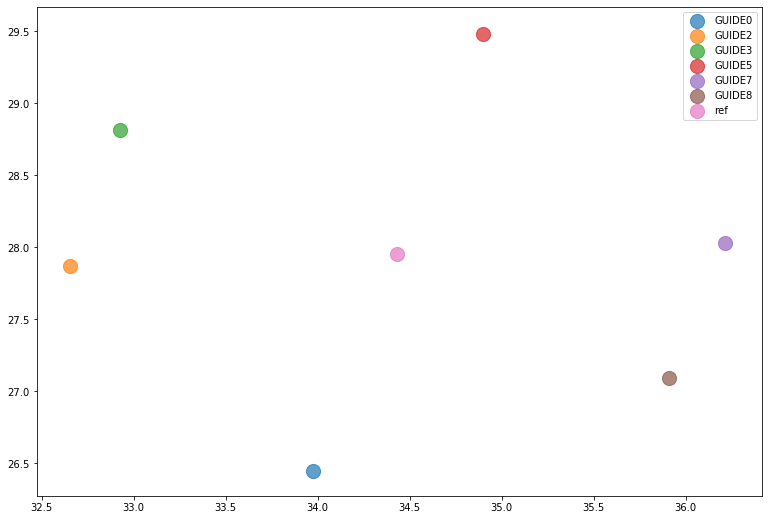

In [3]:
wcs_pm_29056 = """3 32.9259 28.8111 1024.5 516.5 3.4772e-05 4.3973e-05 4.7859e-05 -3.1949e-05
5 34.9007 29.4783 1024.5 516.5 5.6262e-05 -1.6797e-05 -1.8281e-05 -5.1694e-05
7 36.2103 28.0282 1024.5 516.5 -9.0574e-16 -5.4356e-05 -5.9159e-05 8.3221e-16
8 35.9104 27.0927 1024.5 516.5 -3.4773e-05 -4.3975e-05 -4.7861e-05 3.1950e-05
0 33.9724 26.4401 1024.5 516.5 -5.6264e-05 1.6797e-05 1.8281e-05 5.1696e-05
2 32.6524 27.8690 1024.5 516.5 3.0191e-16 5.4355e-05 5.9158e-05 -2.7739e-16"""

WCS_data = {}

ra_list = []
dec_list = []
for gfa in wcs_pm_29056.split('\n'):
    gfa_data = gfa.split()
    WCS_data['GUIDE%s' % gfa_data[0]] = {}
    WCS_data['GUIDE%s' % gfa_data[0]]['CRVAL1'] = float(gfa_data[1])
    ra_list.append(float(gfa_data[1]))
    WCS_data['GUIDE%s' % gfa_data[0]]['CRVAL2'] = float(gfa_data[2])
    dec_list.append(float(gfa_data[2]))
    WCS_data['GUIDE%s' % gfa_data[0]]['CRPIX1'] = float(gfa_data[3])
    WCS_data['GUIDE%s' % gfa_data[0]]['CRPIX2'] = float(gfa_data[4])
    WCS_data['GUIDE%s' % gfa_data[0]]['CD1_1'] = float(gfa_data[5])
    WCS_data['GUIDE%s' % gfa_data[0]]['CD1_2'] = float(gfa_data[6])
    WCS_data['GUIDE%s' % gfa_data[0]]['CD2_1'] = float(gfa_data[7])
    WCS_data['GUIDE%s' % gfa_data[0]]['CD2_2'] = float(gfa_data[8])

ref_ra = np.mean(ra_list)
ref_dec = np.mean(dec_list)

cams = ['GUIDE0', 'GUIDE2', 'GUIDE3', 'GUIDE5', 'GUIDE7', 'GUIDE8']
wcs_gfa = {}
for cam in cams:
    # Load WCS   
    WCS_data[cam]['CTYPE1'] = "RA---TAN" 
    WCS_data[cam]['CTYPE2'] = "DEC--TAN" 
    wcs_gfa[cam] = WCS(WCS_data[cam])

# Load reference WCS from Telescope Sky pointing
wcs_dict = {
    'CTYPE1': 'RA---TAN',
    'CTYPE2': 'DEC--TAN',
    'CRVAL1': ref_ra,
    'CRVAL2': ref_dec,
    'CRPIX1': 0,
    'CRPIX2': 0,
    'CD1_1': 1,
    'CD1_2': 0.0,
    'CD2_1': 0.0,
    'CD2_2': 1
}

wcs_gfa['ref'] = WCS(wcs_dict)
pixel_scale_matrix = proj_plane_pixel_scales(wcs_gfa['GUIDE0'])
pixel_scale = np.mean(pixel_scale_matrix*3600)

for cam in wcs_gfa:
    plt.scatter(wcs_gfa[cam].wcs.crval[0], wcs_gfa[cam].wcs.crval[1], label=cam, s=200, alpha=0.7)
plt.legend()

## SVDfit function

In [4]:
def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t

# CONFIG

In [5]:
exp_num=43860
analysis_range = [0, 500]

centroids_file = 'centroids-%08d.json' % exp_num
centroids = json.load(open(centroids_file))

if analysis_range[1]>len(centroids['frames']):
    analysis_range[1] = len(centroids['frames'])
iteration_array = list(range(analysis_range[0], analysis_range[1]))

## RA/Dec guide signal

Text(0.5, 1.0, 'Guide signal for 43860')

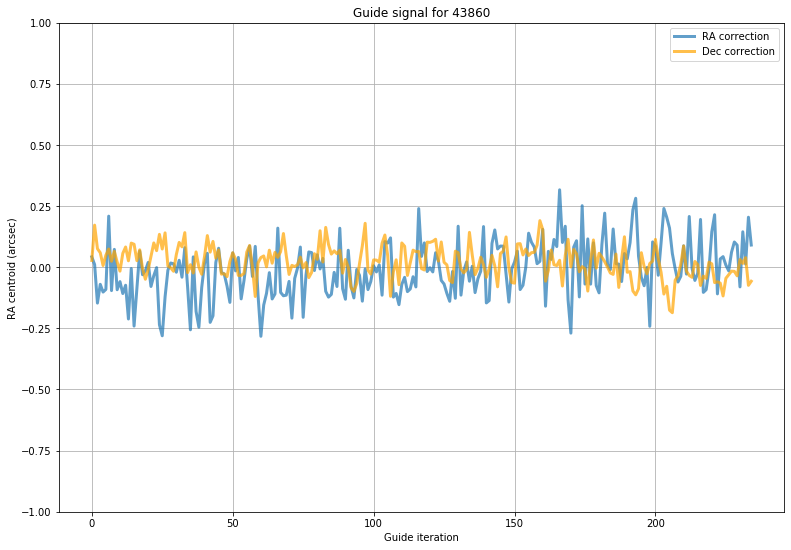

In [6]:
tcs_correction_ra = []
tcs_correction_dec = []
guide_star_ra = {}
guide_star_dec = {}
guide_star_sn = {}
guide_star_centerdist = {}
centroid_error_star_ra = {}
centroid_error_star_dec = {}

# Initialize guidestar arrays
for guidestar in centroids['frames']['1']:
    cam = guidestar.split("_")[0]
    if cam in cams:
        guide_star_ra[guidestar] = []
        guide_star_dec[guidestar] = []
        centroid_error_star_ra[guidestar] = []
        centroid_error_star_dec[guidestar] = []
        guide_star_centerdist[guidestar] = []
        guide_star_sn[guidestar] = centroids['frames']['1'][guidestar]['sn']

# Load all centroid data
for iteration in centroids['frames']:
    if not ((int(iteration) > analysis_range[0]) and (int(iteration) <= analysis_range[1])):
        continue
    tcs_correction_ra.append(centroids['frames'][iteration]['tcs_correction_ra'])
    tcs_correction_dec.append(centroids['frames'][iteration]['tcs_correction_dec'])
    for guidestar in centroids['frames'][iteration]:
        cam = guidestar.split("_")[0]
        if cam in cams:
            if not centroids['frames'][iteration][guidestar]['enabled']:
                guide_star_ra[guidestar].append(None)
                guide_star_dec[guidestar].append(None)
                centroid_error_star_ra[guidestar].append(None)
                centroid_error_star_dec[guidestar].append(None)
            else:
                guide_star_ra[guidestar].append(centroids['frames'][iteration][guidestar]['x_error_wcs']*pixel_scale)
                guide_star_dec[guidestar].append(centroids['frames'][iteration][guidestar]['y_error_wcs']*pixel_scale)
                # Distance from guide star to center of detector
                x_to_center = centroids['frames'][iteration][guidestar]['x_expected'] - (1032/2.)
                y_to_center = centroids['frames'][iteration][guidestar]['y_expected'] - (2248/2.)
                distance_to_center = np.sqrt(x_to_center**2 + y_to_center**2)
                guide_star_centerdist[guidestar] = distance_to_center
                
                centroid_error_star_ra[guidestar].append(guide_star_ra[guidestar][-1] - tcs_correction_ra[-1])
                centroid_error_star_dec[guidestar].append(guide_star_dec[guidestar][-1] - tcs_correction_dec[-1])
        else:
            continue    
            
# PLOT
plt.plot(tcs_correction_ra, label='RA correction', linewidth=3, alpha=0.7)
plt.plot(tcs_correction_dec, label='Dec correction', linewidth=3, color='orange', alpha=0.7)
plt.grid()
plt.legend()
plt.ylim(-1,1)
plt.xlabel('Guide iteration')
plt.ylabel('RA centroid (arcsec)')
plt.title("Guide signal for %d" % exp_num)

## SDVfit

12 guide stars
235 iterations


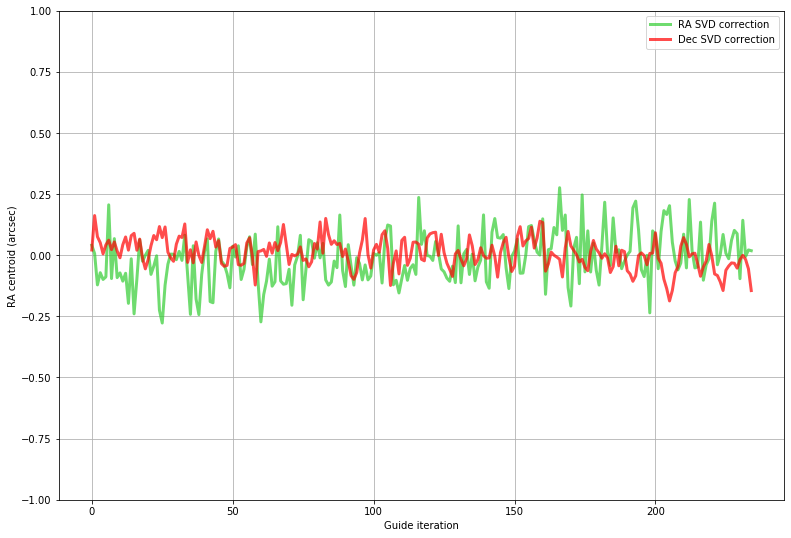

In [7]:
reference_stars = []
cams_list = []

for guidestar in centroids['frames']['1']:
    cam = guidestar.split("_")[0]
    if cam in cams:
        if not centroids['frames']['1'][guidestar]['enabled']:
            continue

        guide_star_sky = wcs_gfa[cam].wcs_pix2world([(centroids['frames']['1'][guidestar]['x_expected'],
                                                      -centroids['frames']['1'][guidestar]['y_expected'])], 0)
        guide_star_xy = wcs_gfa['ref'].wcs_world2pix(guide_star_sky, 1)
        reference_stars.append(guide_star_xy[0])
    else:
        continue
    cams_list.append(guidestar)
    
print ("%d guide stars" % len(cams_list))
    
reference_stars = np.vstack(reference_stars)

rot_correction_svd = []
tcs_correction_ra_svd = []
tcs_correction_dec_svd = []
centroid_error_star_ra_svd = {}
centroid_error_star_dec_svd = {}

# Initialize guidestar arrays
for guidestar in centroids['frames']['1']:
    cam = guidestar.split("_")[0]
    if cam in cams:
        centroid_error_star_ra_svd[guidestar] = []
        centroid_error_star_dec_svd[guidestar] = []


for iteration in centroids['frames']:
  
    if not ((int(iteration) > analysis_range[0]) and (int(iteration) <= analysis_range[1])):
        continue

    iteration_stars = []

    for guidestar in centroids['frames'][iteration]:
        
        cam = guidestar.split("_")[0]
    
        if cam in cams:
            if not centroids['frames']['1'][guidestar]['enabled']:
                continue
            
            guide_star_sky = wcs_gfa[cam].wcs_pix2world([(centroids['frames'][iteration][guidestar]['x_centroid'],
                                                          -centroids['frames'][iteration][guidestar]['y_centroid'])], 0)
            guide_star_xy = wcs_gfa['ref'].wcs_world2pix(guide_star_sky, 1)
            iteration_stars.append(guide_star_xy[0])
        
    iteration_stars = np.vstack(iteration_stars)
    
    T, R1, t1 = best_fit_transform(iteration_stars, reference_stars)
    
    print_svd = False
    
    if print_svd:
        print("offset: %.3f, %.3f arcsec" % (t1[0]*3600, t1[1]*3600))
        print("offset: %.3f, %.3f pixels" % (t1[0]/pixel_scale_matrix[0], t1[1]/pixel_scale_matrix[1]))
        print("rotation: %.6f degrees" % (np.arccos(R1[0][0])*180./np.pi))
    
    tcs_correction_ra_svd.append(-t1[1]*3600)
    tcs_correction_dec_svd.append(t1[0]*3600)
    rot_correction_svd.append(np.arccos(R1[0][0])*180./np.pi)
    
    # Make C a homogeneous representation of B
    C = np.ones((len(iteration_stars), 3))
    C[:,0:2] = iteration_stars
    # Transform C
    C = np.dot(T, C.T).T   
    
    i = 0
    for guidestar in centroids['frames'][iteration]:
        
        cam = guidestar.split("_")[0]
    
        if cam in cams:
            if not centroids['frames']['1'][guidestar]['enabled']:
                centroid_error_star_ra_svd[guidestar].append(None)
                centroid_error_star_dec_svd[guidestar].append(None)
            else:
                centroid_error_star_ra_svd[guidestar].append(((C.T[0:2].T - reference_stars)*3600)[i][1])  
                centroid_error_star_dec_svd[guidestar].append(((C.T[0:2].T - reference_stars)*3600)[i][0])        
                i += 1

print("%d iterations" % len(tcs_correction_ra_svd))

# PLOT
plt.plot(iteration_array, tcs_correction_ra_svd, label='RA SVD correction', linewidth=3, alpha=0.7, color = 'limegreen', linestyle='-')
plt.plot(iteration_array, tcs_correction_dec_svd, label='Dec SVD correction', linewidth=3, alpha=0.7, color = 'red', linestyle='-')
plt.ylim(-1,1)
plt.grid()
plt.xlabel('Guide iteration')
plt.ylabel('RA centroid (arcsec)')
plt.legend()

## SVDfit rotation

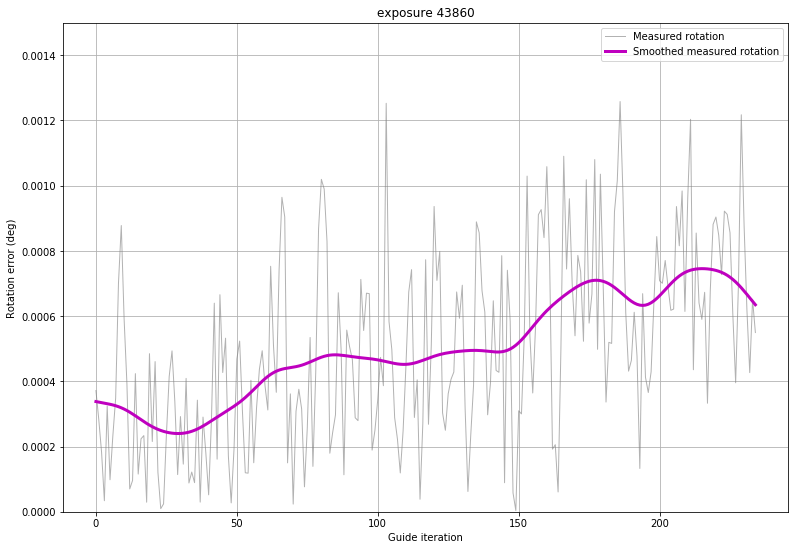

In [8]:
plt.plot(rot_correction_svd, color='grey', linewidth=1, alpha=0.6, label='Measured rotation')

# Avoid nan values in interpolation
rot_sequence_interp = np.array(rot_correction_svd)
ok = ~np.isnan(rot_sequence_interp)
xp = ok.ravel().nonzero()[0]
fp = rot_sequence_interp[~np.isnan(rot_sequence_interp)]
x  = np.isnan(rot_sequence_interp).ravel().nonzero()[0]
rot_sequence_interp[np.isnan(rot_sequence_interp)] = np.interp(x, xp, fp)
rot_smooth = gaussian_filter(rot_sequence_interp, sigma=8, mode='nearest')
plt.plot(rot_smooth, linewidth=3, alpha=1, label='Smoothed measured rotation', color='m')
plt.ylabel("Rotation error (deg)")
plt.xlabel("Guide iteration")
plt.title("exposure %s" % exp_num)
plt.legend()
plt.ylim(0, 0.0015)
plt.grid()

# RA

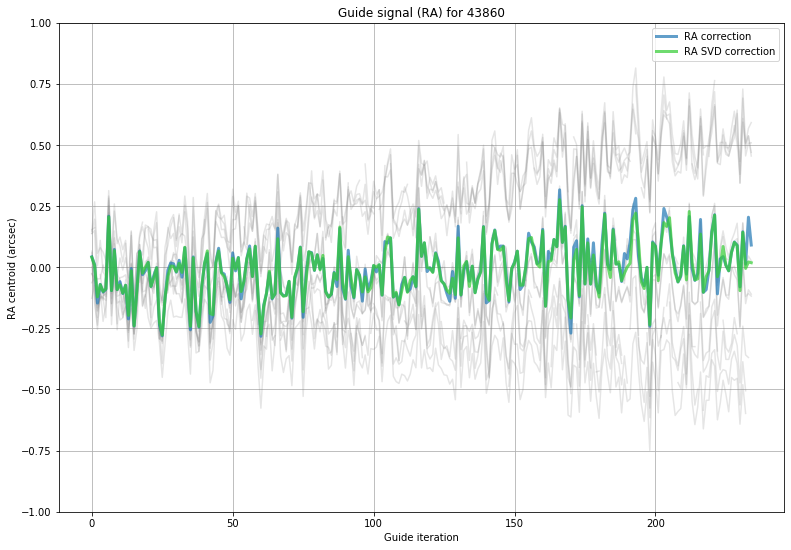

In [9]:
for guidestar in guide_star_ra:
    plt.plot(iteration_array, guide_star_ra[guidestar], alpha=0.2, color='grey')

plt.plot(iteration_array, tcs_correction_ra, label='RA correction', linewidth=3, alpha=0.7)
plt.plot(iteration_array, tcs_correction_ra_svd, label='RA SVD correction', linewidth=3, alpha=0.7, color = 'limegreen', linestyle='-')

plt.ylim(-1,1)

plt.grid()
plt.xlabel('Guide iteration')
plt.ylabel('RA centroid (arcsec)')
plt.title("Guide signal (RA) for %d" % exp_num)
plt.legend()

# DEC

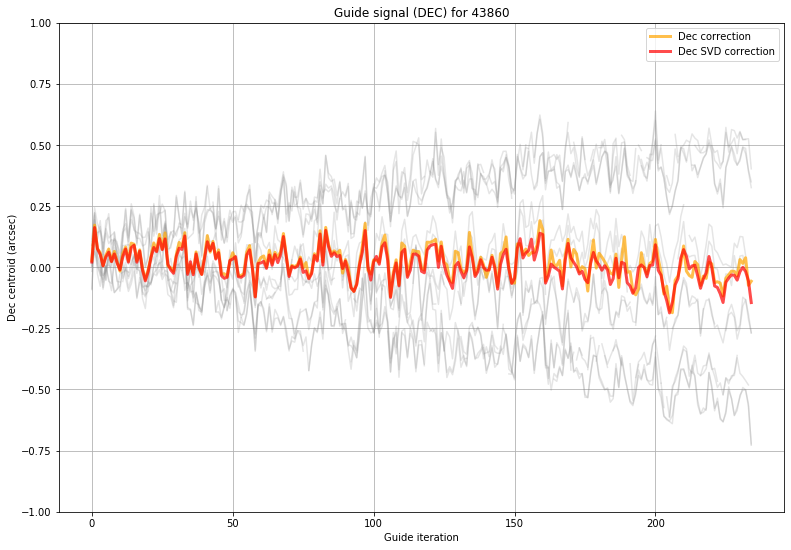

In [10]:
for guidestar in guide_star_ra:
    plt.plot(iteration_array, guide_star_dec[guidestar], alpha=0.2, color='grey')
        
plt.plot(iteration_array, tcs_correction_dec, label='Dec correction', linewidth=3, color='orange', alpha=0.7)
plt.plot(iteration_array, tcs_correction_dec_svd, label='Dec SVD correction', linewidth=3, alpha=0.7, color='red', linestyle='-')

plt.ylim(-1,1)

plt.xlabel('Guide iteration')
plt.ylabel('Dec centroid (arcsec)')
plt.grid()
plt.title("Guide signal (DEC) for %d" % exp_num)
plt.legend()

### Load centroid statistics for requirements

In [11]:
guide_error = []
centroid_error = []

for iteration in centroids['frames']:
    
    if not ((int(iteration) > analysis_range[0]) and (int(iteration) <= analysis_range[1])):
        continue
    
    guide_error.append(np.sqrt((centroids['frames'][iteration]['tcs_correction_ra'])**2 + 
                               (centroids['frames'][iteration]['tcs_correction_dec'])**2))
    
    centroid_error_iteration = []
    for guidestar in centroids['frames'][iteration]:
        if 'GUIDE' not in guidestar:
            continue
            
        if centroids['frames'][iteration][guidestar]['x_error_wcs'] is None:
            continue
        
        centroid_error_x = np.abs(centroids['frames'][iteration][guidestar]['x_error_wcs'] - 
                                  centroids['frames'][iteration]['combined_x']) * pixel_scale
        
        centroid_error_y = np.abs(centroids['frames'][iteration][guidestar]['y_error_wcs'] - 
                                  centroids['frames'][iteration]['combined_y']) * pixel_scale
                
        centroid_error_iteration.append(np.sqrt(centroid_error_x**2 + centroid_error_y**2))
        
        
    centroid_error.append(np.mean(centroid_error_iteration))

## Focal Plane System Requirements (doc #0810)
#### IN.FPA2001 Guide Centroid Accuracy
The FPS shall deliver a tracking error signal better than 0.03 arcseconds, at an update rate of 0.2 Hz, and latency less than 3 seconds. The Mayall telescope can meet its pointing requirements with this accuracy of guide signal. For commissioning and debugging a much higher precision and update rate is advantageous. (DESI-0315)

In [12]:
centroid_error_rms = np.sqrt(np.mean(np.array(centroid_error)**2))
centroid_error_std = np.std(centroid_error)
print("0.030 arcsec GOAL")
print("%.3f arcsec RMS" % centroid_error_rms)
print("%.3f arcsec STD" % centroid_error_std)

0.030 arcsec GOAL
0.371 arcsec RMS
0.140 arcsec STD


## DESI Science Requirements Document (doc #0318)
#### L3.3.3 Telescope guiding accuracy shall be assumed to be 100 mas RMS. Motivation
Required at Level 4 as a component to the fiber positioning accuracy budget. Explanation: This is the historical measured performance of the Mayall. The DESI instrument may see improved performance, as the DECam instrument on the Blanco telescope achieves 50 mas. Verification: This will be measured by the apparent motion of guide stars in the GFAs during commissioning.

In [13]:
guide_error_rms = np.sqrt(np.mean(np.array(guide_error)**2))
guide_error_std = np.std(guide_error)
print("0.100 arcsec GOAL")
print("%.3f arcsec RMS" % guide_error_rms)
print("%.3f arcsec STD" % guide_error_std)

0.100 arcsec GOAL
0.131 arcsec RMS
0.064 arcsec STD
